In [2]:
from ImageProcessor import *
from Evaluation import *
svs_path = '../prelimary_data/BRACS_1494.svs'
json_path = '../prelimary_data/BRACS_1494.geojson'
tile_size = 512

imageProcessor_1494 = ImageProcessor(json_path, svs_path)
tiles_1494 = imageProcessor_1494.generate_tile(tile_size = tile_size)

/home/s4647285/STAT3007/combined_scripts/ImageProcessor.py:82: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  intersections_df = geopandas.overlay(tiles_df, annotations_df, how='intersection')
100%|██████████| 166/166 [05:15<00:00,  1.90s/it]


In [3]:
svs_path = '../prelimary_data/BRACS_1496.svs'
json_path = '../prelimary_data/BRACS_1496.geojson'
imageProcessor_1496 = ImageProcessor(json_path, svs_path)
tiles_1496 = imageProcessor_1496.generate_tile(tile_size = tile_size)

100%|██████████| 174/174 [05:51<00:00,  2.02s/it]


In [4]:
svs_path = '../prelimary_data/BRACS_1286.svs'
json_path = '../prelimary_data/BRACS_1286.geojson'
imageProcessor_1286 = ImageProcessor(json_path, svs_path)
tiles_1286 = imageProcessor_1286.generate_tile(tile_size = tile_size)

100%|██████████| 173/173 [06:51<00:00,  2.38s/it]


In [6]:
len(tiles_1494),len(tiles_1496), len(tiles_1286)

(17552, 8108, 23956)

In [5]:
tiles = tiles_1494 + tiles_1496 + tiles_1286

In [7]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import relu
import json
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np

class UNet(nn.Module):
    """
    Base Unet Implementation
    """

    def __init__(self, n_class:int = 2) -> None:
        """
        Initialize Unet, n_class is number of classes we want to segment images for
        Defaults at 2 for 2 ROI types
        """
        super().__init__()

        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image.
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 572x572x3
        self.e11 = nn.Conv2d(3, 64, kernel_size=3, padding=1) # output: 570x570x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 568x568x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 284x284x64

        # input: 284x284x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 282x282x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 280x280x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 140x140x128

        # input: 140x140x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 138x138x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 136x136x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 68x68x256

        # input: 68x68x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 66x66x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 64x64x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x512

        # input: 32x32x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # output: 30x30x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 28x28x1024


        # Decoder
        # In the decoder, transpose convolutional layers with the ConvTranspose2d function are used to upsample the feature maps to the original size of the input image.
        # Each block in the decoder consists of an upsampling layer, a concatenation with the corresponding encoder feature map, and two convolutional layers.
        # -------
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))

        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out

In [8]:
# @title
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import relu
import json
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np

class SmallUNet(nn.Module):
    """
    Base Unet Implementation
    """

    def __init__(self, n_class:int = 2) -> None:
        """
        Initialize Unet, n_class is number of classes we want to segment images for
        Defaults at 2 for 2 ROI types
        """
        super().__init__()

        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image.
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 572x572x3

        self.e21 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.e22 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # input: 284x284x64
        self.e31 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.e32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) #

        # input: 140x140x128
        self.e41 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.e42 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # input: 68x68x256
        self.e51 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.e52 = nn.Conv2d(512, 512, kernel_size=3, padding=1)


        # Decoder
        # In the decoder, transpose convolutional layers with the ConvTranspose2d function are used to upsample the feature maps to the original size of the input image.
        # Each block in the decoder consists of an upsampling layer, a concatenation with the corresponding encoder feature map, and two convolutional layers.
        # -------
        self.upconv1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)
        self.sigmoid = nn.LogSoftmax(dim=1)

    def forward(self, x):

        xe21 = relu(self.e21(x))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))

        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        # Output layer
        out = self.outconv(xd32)
        #out = self.sigmoid(out)

        return out

In [9]:
import random
import numpy as np
import torch

def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

set_seeds(32)

In [10]:
tiles = [t for t in tiles if t.image_data.shape == (3, tile_size, tile_size)]
tiles_copy = tiles

In [11]:
tiles_with_masks = [t for t in tiles if 1 in t.mask]
print(len(tiles_with_masks))
tiles = tiles_with_masks + list(np.random.choice(tiles, 3*len(tiles_with_masks), replace=False))
print(len(tiles))

743
2972


In [12]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class TiledWSIDataset(Dataset):
    def __init__(self, tiles):
        self.tiles = [t.image_data for t in tiles]
        self.masks = [t.mask for t in tiles]
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.tiles)

    def __len__(self):
        return len(self.tiles)

    def __getitem__(self, idx):
        image = self.tiles[idx]
        image = image.transpose(1, 2, 0)

        image = self.transform(image)

        mask = self.masks[idx]
        mask = torch.tensor(mask)
        return image, mask

dataset = TiledWSIDataset(tiles)
full_dataset = DataLoader(dataset, batch_size=16, shuffle=True)

In [13]:
from torch.optim import Adam

def dice_loss(pred, target):
    smooth = 1.
    iflat = pred.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()

    return 1 - ((2. * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

def criterion(pred, target):
    return dice_loss(pred, target) + F.cross_entropy(pred, target)


In [14]:
from torch.utils.data import random_split, DataLoader


# Split the smaller dataset into training and testing
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

batch_size = 16

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)


In [15]:
import torch
torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device(type='cuda')

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(n_class=1).to(device)

lr = 1e-4
optimizer = Adam(model.parameters(), lr=lr)

criterion = nn.BCEWithLogitsLoss()

def train(model, trainloader, testloader, criterion, optimizer, epochs, device):
  best_test = np.inf
  train_losses = []
  test_losses = []


  for epoch in range(epochs):
    epoch_loss = 0
    test_loss = 0

    model.train()
    for images, masks in tqdm(trainloader):

      images, masks = images.to(device), masks.to(device)

      optimizer.zero_grad()

      outputs = model(images)

      loss = criterion(outputs, masks)
      loss.backward()
      optimizer.step()
      loss = loss.cpu()
      epoch_loss += loss.item()

    model.eval()
    for image, masks in tqdm(testloader):
      images, masks = images.to(device), masks.to(device)
      outputs = model(images)
      loss = criterion(outputs, masks)
      loss = loss.cpu()
      test_loss += loss.item()

      
    epoch_train_loss = epoch_loss / len(trainloader)
    epoch_test_loss = test_loss / len(testloader)

    train_losses.append(epoch_train_loss)
    test_losses.append(epoch_test_loss)

    if test_loss/len(testloader) < best_test:
      best_test = test_loss/len(testloader)
      lr_str = str(lr)
      tile_size_str = str(tile_size)
      torch.save(model.state_dict(), 'unet_' + lr_str + "_" + tile_size_str + 'pth')

    print(f'Epoch {epoch+1}, Train Loss: {epoch_loss/len(trainloader)}, Test Loss: {test_loss/len(testloader)}')

  return train_losses, test_losses

    # plt.figure(figsize=(10, 5))
    # plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', color='red')
    # plt.plot(range(1, epochs + 1), test_losses, label='Test Loss', color='blue')
    # plt.xlabel('Epochs')
    # plt.ylabel('Loss')
    # plt.title('Train and Test Loss Over Epochs')
    # plt.legend()
    # plt.grid(True)
    # plt.show()


In [32]:
num_iterates = 50
UNet_trained = train(model, train_loader, test_loader, criterion, optimizer, num_iterates, device)

100%|██████████| 37/37 [00:08<00:00,  4.12it/s]


Epoch 1, Train Loss: 0.37498974795075685, Test Loss: 0.44487153638053584


100%|██████████| 37/37 [00:10<00:00,  3.70it/s]


Epoch 2, Train Loss: 0.33818043697927447, Test Loss: 0.4317910554441246


100%|██████████| 37/37 [00:09<00:00,  4.03it/s]


Epoch 3, Train Loss: 0.3336957660377831, Test Loss: 0.426611891872174


100%|██████████| 37/37 [00:09<00:00,  3.91it/s]


Epoch 4, Train Loss: 0.3321588386756343, Test Loss: 0.4490705108320391


100%|██████████| 37/37 [00:08<00:00,  4.39it/s]


Epoch 5, Train Loss: 0.3287401965039002, Test Loss: 0.42627254652010427


100%|██████████| 37/37 [00:08<00:00,  4.28it/s]


Epoch 6, Train Loss: 0.32802170736564173, Test Loss: 0.4344993507539904


100%|██████████| 37/37 [00:08<00:00,  4.23it/s]


Epoch 7, Train Loss: 0.327137142017081, Test Loss: 0.4541687792217409


100%|██████████| 37/37 [00:09<00:00,  3.83it/s]


Epoch 8, Train Loss: 0.322201463821772, Test Loss: 0.4491972597064199


100%|██████████| 37/37 [00:08<00:00,  4.33it/s]


Epoch 9, Train Loss: 0.3145489362446037, Test Loss: 0.5050644685287733


100%|██████████| 37/37 [00:08<00:00,  4.18it/s]


Epoch 10, Train Loss: 0.3134782730626899, Test Loss: 0.46049695965406057


100%|██████████| 37/37 [00:09<00:00,  4.00it/s]


Epoch 11, Train Loss: 0.30581429001648686, Test Loss: 0.49347686485664266


100%|██████████| 37/37 [00:08<00:00,  4.29it/s]


Epoch 12, Train Loss: 0.3057524896151311, Test Loss: 0.47645769852238734


100%|██████████| 37/37 [00:08<00:00,  4.24it/s]


Epoch 13, Train Loss: 0.3002442901299612, Test Loss: 0.47304821699052246


100%|██████████| 37/37 [00:09<00:00,  3.75it/s]


Epoch 14, Train Loss: 0.29811044636409023, Test Loss: 0.4923109355810526


100%|██████████| 37/37 [00:08<00:00,  4.34it/s]


Epoch 15, Train Loss: 0.29601981465679567, Test Loss: 0.48054881071722183


100%|██████████| 37/37 [00:09<00:00,  3.98it/s]


Epoch 16, Train Loss: 0.29451777886699987, Test Loss: 0.44049144798033946


100%|██████████| 37/37 [00:08<00:00,  4.38it/s]


Epoch 17, Train Loss: 0.28902731058061926, Test Loss: 0.5015121889678208


100%|██████████| 37/37 [00:09<00:00,  3.83it/s]


Epoch 18, Train Loss: 0.2900003629761773, Test Loss: 0.5324647559507473


100%|██████████| 37/37 [00:09<00:00,  3.73it/s]


Epoch 19, Train Loss: 0.2877557447834595, Test Loss: 0.5037754468015723


100%|██████████| 37/37 [00:09<00:00,  3.77it/s]


Epoch 20, Train Loss: 0.2871068469877984, Test Loss: 0.5018003554763021


100%|██████████| 37/37 [00:09<00:00,  3.95it/s]


Epoch 21, Train Loss: 0.28831431294816573, Test Loss: 0.4628389050831666


100%|██████████| 37/37 [00:09<00:00,  3.99it/s]


Epoch 22, Train Loss: 0.2871171279332122, Test Loss: 0.5529597546603229


100%|██████████| 37/37 [00:08<00:00,  4.28it/s]


Epoch 23, Train Loss: 0.2855302661506308, Test Loss: 0.5024444376294678


100%|██████████| 37/37 [00:08<00:00,  4.37it/s]


Epoch 24, Train Loss: 0.2816367438818152, Test Loss: 0.4648073508932784


100%|██████████| 37/37 [00:08<00:00,  4.41it/s]


Epoch 25, Train Loss: 0.28426824943036644, Test Loss: 0.5564059558752421


100%|██████████| 37/37 [00:08<00:00,  4.35it/s]


Epoch 26, Train Loss: 0.28109936833985755, Test Loss: 0.5273282527923584


100%|██████████| 37/37 [00:09<00:00,  3.98it/s]


Epoch 27, Train Loss: 0.28084337545206417, Test Loss: 0.5306755952738427


100%|██████████| 37/37 [00:08<00:00,  4.34it/s]


Epoch 28, Train Loss: 0.2768251803779119, Test Loss: 0.46976258525171793


100%|██████████| 37/37 [00:09<00:00,  3.88it/s]


Epoch 29, Train Loss: 0.27612176633163077, Test Loss: 0.5649346886454402


100%|██████████| 37/37 [00:08<00:00,  4.23it/s]


Epoch 30, Train Loss: 0.27465077544990424, Test Loss: 0.6029612518645622


100%|██████████| 37/37 [00:08<00:00,  4.28it/s]


Epoch 31, Train Loss: 0.27164040108186166, Test Loss: 0.5376968117984565


100%|██████████| 37/37 [00:08<00:00,  4.21it/s]


Epoch 32, Train Loss: 0.27153384599935365, Test Loss: 0.5966856886406202


100%|██████████| 37/37 [00:08<00:00,  4.37it/s]


Epoch 33, Train Loss: 0.26739284129360236, Test Loss: 0.5033400268168062


100%|██████████| 37/37 [00:08<00:00,  4.23it/s]


Epoch 34, Train Loss: 0.26108061446732767, Test Loss: 0.5406387029467402


100%|██████████| 37/37 [00:08<00:00,  4.21it/s]


Epoch 35, Train Loss: 0.26099957372187765, Test Loss: 0.5523514159627863


100%|██████████| 37/37 [00:08<00:00,  4.29it/s]


Epoch 36, Train Loss: 0.2536703831188985, Test Loss: 0.5596346830999529


100%|██████████| 37/37 [00:08<00:00,  4.31it/s]


Epoch 37, Train Loss: 0.2481726943137678, Test Loss: 0.6439128348956237


100%|██████████| 37/37 [00:08<00:00,  4.33it/s]


Epoch 38, Train Loss: 0.23910807712456664, Test Loss: 0.7071773067519471


100%|██████████| 37/37 [00:08<00:00,  4.25it/s]


Epoch 39, Train Loss: 0.23003908865959258, Test Loss: 0.6816359975853482


100%|██████████| 37/37 [00:09<00:00,  3.72it/s]


Epoch 40, Train Loss: 0.2186872220623332, Test Loss: 0.6237459392160982


100%|██████████| 37/37 [00:08<00:00,  4.31it/s]


Epoch 41, Train Loss: 0.19950723086760655, Test Loss: 0.666740292632902


100%|██████████| 37/37 [00:09<00:00,  3.71it/s]


Epoch 42, Train Loss: 0.1793760161695851, Test Loss: 0.7937099450343365


100%|██████████| 37/37 [00:10<00:00,  3.66it/s]


Epoch 43, Train Loss: 0.15967168895578063, Test Loss: 0.788771595906567


100%|██████████| 37/37 [00:08<00:00,  4.26it/s]


Epoch 44, Train Loss: 0.1268331883978602, Test Loss: 1.2006675713771098


100%|██████████| 37/37 [00:10<00:00,  3.66it/s]


Epoch 45, Train Loss: 0.1067167447779227, Test Loss: 1.0491503549588692


100%|██████████| 37/37 [00:09<00:00,  3.76it/s]


Epoch 46, Train Loss: 0.0874849854074922, Test Loss: 1.3960572191186853


100%|██████████| 37/37 [00:08<00:00,  4.18it/s]


Epoch 47, Train Loss: 0.07166941503591433, Test Loss: 1.5029096458409283


100%|██████████| 37/37 [00:09<00:00,  3.72it/s]


Epoch 48, Train Loss: 0.056590698609078255, Test Loss: 1.1964031184041821


100%|██████████| 37/37 [00:08<00:00,  4.34it/s]


Epoch 49, Train Loss: 0.050270379885930465, Test Loss: 1.1553050738734167


100%|██████████| 37/37 [00:09<00:00,  3.73it/s]

Epoch 50, Train Loss: 0.03986018579579084, Test Loss: 2.6880118589143494


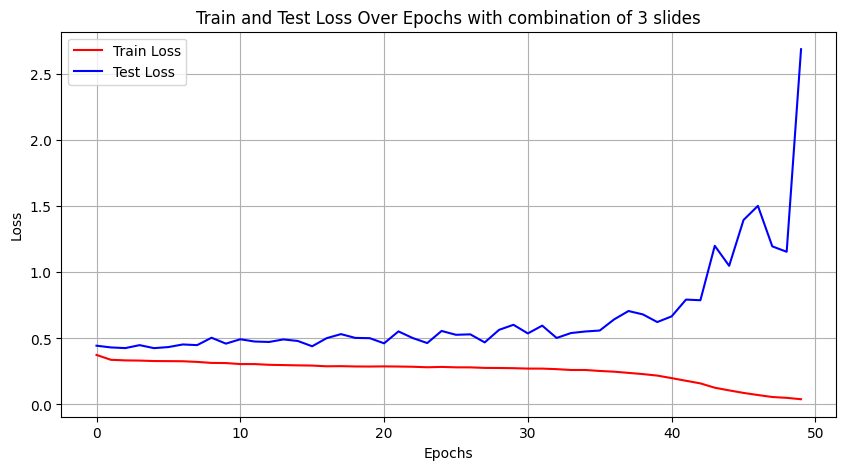

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(range(num_iterates), UNet_trained[0], label='Train Loss', color='red')
plt.plot(range(num_iterates), UNet_trained[1], label='Test Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss Over Epochs with combination of 3 slides') #10^-4 
plt.legend()
plt.grid(True)
plt.show()

In [36]:
confusion_matrix_1 = compute_confusion_matrix(model, dataset, device)
eval = evaluate_model(model, dataset, device)

  0%|          | 0/2972 [00:00<?, ?it/s]


RuntimeError: Given groups=1, weight of size [512, 1024, 3, 3], expected input[1, 512, 128, 64] to have 1024 channels, but got 512 channels instead

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_1 = UNet(n_class=1).to(device)

lr = 1e-6
optimizer = Adam(model_1.parameters(), lr=lr)

criterion = nn.BCEWithLogitsLoss()

def train(model, trainloader, testloader, criterion, optimizer, epochs, device):
  best_test = np.inf
  train_losses = []
  test_losses = []


  for epoch in range(epochs):
    epoch_loss = 0
    test_loss = 0

    model.train()
    for images, masks in tqdm(trainloader):

      images, masks = images.to(device), masks.to(device)

      optimizer.zero_grad()

      outputs = model(images)

      loss = criterion(outputs, masks)
      loss.backward()
      optimizer.step()
      loss = loss.cpu()
      epoch_loss += loss.item()

    model.eval()
    for image, masks in tqdm(testloader):
      images, masks = images.to(device), masks.to(device)
      outputs = model(images)
      loss = criterion(outputs, masks)
      loss = loss.cpu()
      test_loss += loss.item()

      
    epoch_train_loss = epoch_loss / len(trainloader)
    epoch_test_loss = test_loss / len(testloader)

    train_losses.append(epoch_train_loss)
    test_losses.append(epoch_test_loss)

    if test_loss/len(testloader) < best_test:
      best_test = test_loss/len(testloader)
      lr_str = str(lr)
      tile_size_str = str(tile_size)
      torch.save(model.state_dict(), 'unet_' + lr_str + "_" + tile_size_str + '_' + str(epochs) + '.pth')

    print(f'Epoch {epoch+1}, Train Loss: {epoch_loss/len(trainloader)}, Test Loss: {test_loss/len(testloader)}')

  return train_losses, test_losses

    # plt.figure(figsize=(10, 5))
    # plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', color='red')
    # plt.plot(range(1, epochs + 1), test_losses, label='Test Loss', color='blue')
    # plt.xlabel('Epochs')
    # plt.ylabel('Loss')
    # plt.title('Train and Test Loss Over Epochs')
    # plt.legend()
    # plt.grid(True)
    # plt.show()


In [40]:
num_iterates = 50
UNet_trained_1 = train(model_1, train_loader, test_loader, criterion, optimizer, num_iterates, device)

100%|██████████| 37/37 [00:08<00:00,  4.25it/s]


Epoch 1, Train Loss: 0.7227577631537979, Test Loss: 0.716334847179619


100%|██████████| 37/37 [00:08<00:00,  4.29it/s]


Epoch 2, Train Loss: 0.7081976053682534, Test Loss: 0.7001308798789978


100%|██████████| 37/37 [00:08<00:00,  4.13it/s]


Epoch 3, Train Loss: 0.6905914343692161, Test Loss: 0.6890250347756051


100%|██████████| 37/37 [00:08<00:00,  4.25it/s]


Epoch 4, Train Loss: 0.6595338764222892, Test Loss: 0.6289166018769548


100%|██████████| 37/37 [00:10<00:00,  3.65it/s]


Epoch 5, Train Loss: 0.4201721946734029, Test Loss: 0.4189244307376243


100%|██████████| 37/37 [00:09<00:00,  4.00it/s]


Epoch 6, Train Loss: 0.3461404320960109, Test Loss: 0.39659130210812027


100%|██████████| 37/37 [00:08<00:00,  4.28it/s]


Epoch 7, Train Loss: 0.34504884556942694, Test Loss: 0.3897359222173691


100%|██████████| 37/37 [00:08<00:00,  4.18it/s]


Epoch 8, Train Loss: 0.3451403663871256, Test Loss: 0.41621267715015925


100%|██████████| 37/37 [00:08<00:00,  4.33it/s]


Epoch 9, Train Loss: 0.3442750175961772, Test Loss: 0.41033118117499995


100%|██████████| 37/37 [00:09<00:00,  3.71it/s]


Epoch 10, Train Loss: 0.34152032092616363, Test Loss: 0.4133490899930129


100%|██████████| 37/37 [00:08<00:00,  4.31it/s]


Epoch 11, Train Loss: 0.3420893592709625, Test Loss: 0.41261891658241684


100%|██████████| 37/37 [00:08<00:00,  4.26it/s]


Epoch 12, Train Loss: 0.3399616104827539, Test Loss: 0.4076183957828058


100%|██████████| 37/37 [00:09<00:00,  3.79it/s]


Epoch 13, Train Loss: 0.3391197266409526, Test Loss: 0.4139324112518414


100%|██████████| 37/37 [00:08<00:00,  4.31it/s]


Epoch 14, Train Loss: 0.3393587990588433, Test Loss: 0.40736631646349625


100%|██████████| 37/37 [00:08<00:00,  4.31it/s]


Epoch 15, Train Loss: 0.33988854550832026, Test Loss: 0.41361862783496445


100%|██████████| 37/37 [00:08<00:00,  4.30it/s]


Epoch 16, Train Loss: 0.3388563104074549, Test Loss: 0.4223378779920372


100%|██████████| 37/37 [00:08<00:00,  4.30it/s]


Epoch 17, Train Loss: 0.3381315881034007, Test Loss: 0.4022628987157667


100%|██████████| 37/37 [00:08<00:00,  4.31it/s]


Epoch 18, Train Loss: 0.3376092975204055, Test Loss: 0.4003193249573579


100%|██████████| 37/37 [00:09<00:00,  4.01it/s]


Epoch 19, Train Loss: 0.3360763566216102, Test Loss: 0.4178885459094434


100%|██████████| 37/37 [00:08<00:00,  4.25it/s]


Epoch 20, Train Loss: 0.3367479121362841, Test Loss: 0.4091211021751971


100%|██████████| 37/37 [00:08<00:00,  4.16it/s]


Epoch 21, Train Loss: 0.3354121312196996, Test Loss: 0.3958739134910944


100%|██████████| 37/37 [00:08<00:00,  4.29it/s]


Epoch 22, Train Loss: 0.3343638293948528, Test Loss: 0.41706044569208817


100%|██████████| 37/37 [00:08<00:00,  4.39it/s]


Epoch 23, Train Loss: 0.333604442509445, Test Loss: 0.39662603147932


100%|██████████| 37/37 [00:10<00:00,  3.66it/s]


Epoch 24, Train Loss: 0.33356723597122206, Test Loss: 0.40765898533769557


100%|██████████| 37/37 [00:08<00:00,  4.16it/s]


Epoch 25, Train Loss: 0.33124408538679817, Test Loss: 0.3976330269832869


100%|██████████| 37/37 [00:08<00:00,  4.30it/s]


Epoch 26, Train Loss: 0.33115032989833804, Test Loss: 0.4222843977245125


100%|██████████| 37/37 [00:08<00:00,  4.22it/s]


Epoch 27, Train Loss: 0.33226214480158445, Test Loss: 0.4049262392359811


100%|██████████| 37/37 [00:08<00:00,  4.19it/s]


Epoch 28, Train Loss: 0.330320846138371, Test Loss: 0.4169638237437686


100%|██████████| 37/37 [00:09<00:00,  3.83it/s]


Epoch 29, Train Loss: 0.3307563783349218, Test Loss: 0.41416489111410604


100%|██████████| 37/37 [00:09<00:00,  3.71it/s]


Epoch 30, Train Loss: 0.3320029817924306, Test Loss: 0.4110500143991934


100%|██████████| 37/37 [00:08<00:00,  4.29it/s]


Epoch 31, Train Loss: 0.33040522436636527, Test Loss: 0.4110292021084476


100%|██████████| 37/37 [00:09<00:00,  3.70it/s]


Epoch 32, Train Loss: 0.32900879567338004, Test Loss: 0.41337360361137904


100%|██████████| 37/37 [00:10<00:00,  3.68it/s]


Epoch 33, Train Loss: 0.32838682568556554, Test Loss: 0.4126870265683612


100%|██████████| 37/37 [00:09<00:00,  3.81it/s]


Epoch 34, Train Loss: 0.3281700784290159, Test Loss: 0.413723886013031


100%|██████████| 37/37 [00:09<00:00,  3.72it/s]


Epoch 35, Train Loss: 0.3273499562228854, Test Loss: 0.4243400850006052


100%|██████████| 37/37 [00:08<00:00,  4.36it/s]


Epoch 36, Train Loss: 0.326290458793173, Test Loss: 0.4421422936626383


100%|██████████| 37/37 [00:08<00:00,  4.17it/s]


Epoch 37, Train Loss: 0.325755367961687, Test Loss: 0.42640420633393367


100%|██████████| 37/37 [00:09<00:00,  3.75it/s]


Epoch 38, Train Loss: 0.32553494147755, Test Loss: 0.4358327839825604


100%|██████████| 37/37 [00:08<00:00,  4.20it/s]


Epoch 39, Train Loss: 0.3246175037143198, Test Loss: 0.42126077453832367


100%|██████████| 37/37 [00:08<00:00,  4.18it/s]


Epoch 40, Train Loss: 0.32429263257497065, Test Loss: 0.41348971305666743


100%|██████████| 37/37 [00:09<00:00,  3.72it/s]


Epoch 41, Train Loss: 0.32375748606549726, Test Loss: 0.43039505868344696


100%|██████████| 37/37 [00:08<00:00,  4.17it/s]


Epoch 42, Train Loss: 0.3231644859990558, Test Loss: 0.43323698015631856


100%|██████████| 37/37 [00:09<00:00,  3.86it/s]


Epoch 43, Train Loss: 0.3204655656339349, Test Loss: 0.4342032020559182


100%|██████████| 37/37 [00:08<00:00,  4.18it/s]


Epoch 44, Train Loss: 0.3215728496780267, Test Loss: 0.4205830612698117


100%|██████████| 37/37 [00:09<00:00,  3.78it/s]


Epoch 45, Train Loss: 0.31860770657658577, Test Loss: 0.4314569983933423


100%|██████████| 37/37 [00:08<00:00,  4.18it/s]


Epoch 46, Train Loss: 0.31862189862373713, Test Loss: 0.4437551558823199


100%|██████████| 37/37 [00:08<00:00,  4.27it/s]


Epoch 47, Train Loss: 0.3187955174897168, Test Loss: 0.4437333381659276


100%|██████████| 37/37 [00:09<00:00,  3.75it/s]


Epoch 48, Train Loss: 0.3164471155787642, Test Loss: 0.4410127739648561


100%|██████████| 37/37 [00:08<00:00,  4.18it/s]


Epoch 49, Train Loss: 0.31628493330365903, Test Loss: 0.43900337573644277


100%|██████████| 37/37 [00:08<00:00,  4.20it/s]

Epoch 50, Train Loss: 0.3139468222554471, Test Loss: 0.4330272473193504


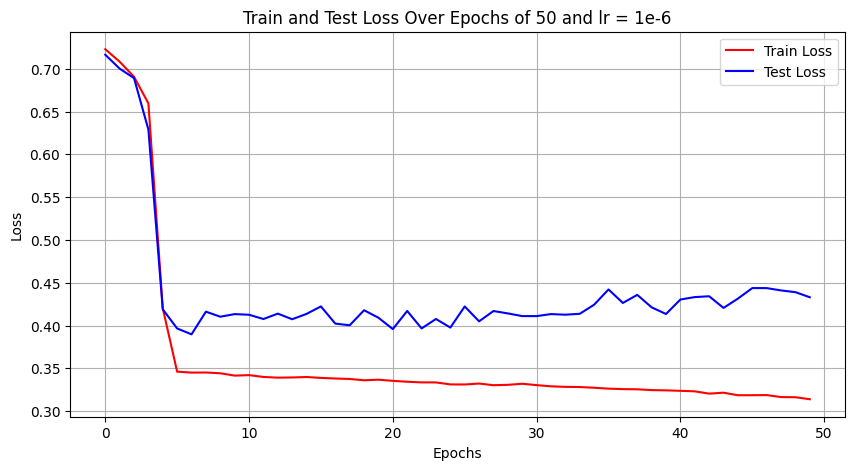

In [41]:
plt.figure(figsize=(10, 5))
plt.plot(range(num_iterates), UNet_trained_1[0], label='Train Loss', color='red')
plt.plot(range(num_iterates), UNet_trained_1[1], label='Test Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss Over Epochs of 50 and lr = 1e-6')
plt.legend()
plt.grid(True)
plt.show()

In [52]:
import time
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_2 = UNet(n_class=1).to(device)

lr = 1e-6
optimizer = Adam(model_2.parameters(), lr=lr)

criterion = nn.BCEWithLogitsLoss()

def train(model, trainloader, testloader, criterion, optimizer, epochs, device):
  best_test = np.inf
  train_losses = []
  test_losses = []

  start_time = time.time()

  for epoch in range(epochs):
    epoch_loss = 0
    test_loss = 0
    epoch_start_time = time.time()


    model.train()
    for images, masks in tqdm(trainloader):

      images, masks = images.to(device), masks.to(device)

      optimizer.zero_grad()

      outputs = model(images)

      loss = criterion(outputs, masks)
      loss.backward()
      optimizer.step()
      loss = loss.cpu()
      epoch_loss += loss.item()

    model.eval()
    for image, masks in tqdm(testloader):
      images, masks = images.to(device), masks.to(device)
      outputs = model(images)
      loss = criterion(outputs, masks)
      loss = loss.cpu()
      test_loss += loss.item()

      
    epoch_train_loss = epoch_loss / len(trainloader)
    epoch_test_loss = test_loss / len(testloader)

    train_losses.append(epoch_train_loss)
    test_losses.append(epoch_test_loss)

    if test_loss/len(testloader) < best_test:
      best_test = test_loss/len(testloader)
      lr_str = str(lr)
      tile_size_str = str(tile_size)
      torch.save(model.state_dict(), 'unet_' + lr_str + "_" + tile_size_str + '_' + str(epochs) + '.pth')

    epoch_duration = time.time() - epoch_start_time
    print(f'Epoch {epoch+1}, Train Loss: {epoch_loss/len(trainloader)}, Test Loss: {test_loss/len(testloader)}')

  total_duration = time.time() - start_time
  total_duration_minutes = total_duration / 60
  print(f'Total Training Time: {total_duration_minutes:.2f} minutes')

  return train_losses, test_losses

    # plt.figure(figsize=(10, 5))
    # plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', color='red')
    # plt.plot(range(1, epochs + 1), test_losses, label='Test Loss', color='blue')
    # plt.xlabel('Epochs')
    # plt.ylabel('Loss')
    # plt.title('Train and Test Loss Over Epochs')
    # plt.legend()
    # plt.grid(True)
    # plt.show()


In [53]:
num_iterates = 100
UNet_trained_2 = train(model_2, train_loader, test_loader, criterion, optimizer, num_iterates, device)

100%|██████████| 37/37 [00:08<00:00,  4.24it/s]


Epoch 1, Train Loss: 0.704665337462683, Test Loss: 0.6979683508744111


100%|██████████| 37/37 [00:08<00:00,  4.31it/s]


Epoch 2, Train Loss: 0.6821940770825824, Test Loss: 0.6726618811890885


100%|██████████| 37/37 [00:08<00:00,  4.12it/s]


Epoch 3, Train Loss: 0.6525642344275037, Test Loss: 0.6413781207961005


100%|██████████| 37/37 [00:08<00:00,  4.30it/s]


Epoch 4, Train Loss: 0.6092798335326685, Test Loss: 0.5828633517832369


100%|██████████| 37/37 [00:09<00:00,  3.97it/s]


Epoch 5, Train Loss: 0.4258889142121818, Test Loss: 0.39858655027441076


100%|██████████| 37/37 [00:09<00:00,  3.84it/s]


Epoch 6, Train Loss: 0.3481513084592046, Test Loss: 0.40693058838715424


100%|██████████| 37/37 [00:09<00:00,  3.86it/s]


Epoch 7, Train Loss: 0.3464867533562151, Test Loss: 0.40288260820749644


100%|██████████| 37/37 [00:09<00:00,  4.07it/s]


Epoch 8, Train Loss: 0.34540006014946345, Test Loss: 0.4043195138911943


100%|██████████| 37/37 [00:08<00:00,  4.14it/s]


Epoch 9, Train Loss: 0.34541975354423393, Test Loss: 0.4065940847267976


100%|██████████| 37/37 [00:08<00:00,  4.30it/s]


Epoch 10, Train Loss: 0.3438094446586596, Test Loss: 0.4052401495140952


100%|██████████| 37/37 [00:10<00:00,  3.69it/s]


Epoch 11, Train Loss: 0.3426873504712775, Test Loss: 0.39144846152614904


100%|██████████| 37/37 [00:10<00:00,  3.60it/s]


Epoch 12, Train Loss: 0.342335348596444, Test Loss: 0.40406230978063634


100%|██████████| 37/37 [00:08<00:00,  4.40it/s]


Epoch 13, Train Loss: 0.34183747472392545, Test Loss: 0.39921212679631


100%|██████████| 37/37 [00:08<00:00,  4.21it/s]


Epoch 14, Train Loss: 0.34210728269976537, Test Loss: 0.41252633929252625


100%|██████████| 37/37 [00:09<00:00,  4.00it/s]


Epoch 15, Train Loss: 0.3396070559282561, Test Loss: 0.39455273062796203


100%|██████████| 37/37 [00:08<00:00,  4.31it/s]


Epoch 16, Train Loss: 0.3404969954611482, Test Loss: 0.4035537470434163


100%|██████████| 37/37 [00:09<00:00,  3.72it/s]


Epoch 17, Train Loss: 0.33783619161191825, Test Loss: 0.3897966448519681


100%|██████████| 37/37 [00:09<00:00,  3.86it/s]


Epoch 18, Train Loss: 0.3392373056125802, Test Loss: 0.41570914315210805


100%|██████████| 37/37 [00:09<00:00,  3.94it/s]


Epoch 19, Train Loss: 0.3391317481527457, Test Loss: 0.4057771132604496


100%|██████████| 37/37 [00:08<00:00,  4.17it/s]


Epoch 20, Train Loss: 0.33747767984262994, Test Loss: 0.3993173479228406


100%|██████████| 37/37 [00:08<00:00,  4.18it/s]


Epoch 21, Train Loss: 0.336417457944638, Test Loss: 0.40731305367237813


100%|██████████| 37/37 [00:08<00:00,  4.24it/s]


Epoch 22, Train Loss: 0.3376076723876837, Test Loss: 0.4165493866076341


100%|██████████| 37/37 [00:09<00:00,  3.84it/s]


Epoch 23, Train Loss: 0.33672757874670867, Test Loss: 0.41196714824921377


100%|██████████| 37/37 [00:08<00:00,  4.26it/s]


Epoch 24, Train Loss: 0.3357355767307249, Test Loss: 0.3923331039982873


100%|██████████| 37/37 [00:10<00:00,  3.61it/s]


Epoch 25, Train Loss: 0.3361732627995111, Test Loss: 0.4114431489158321


100%|██████████| 37/37 [00:08<00:00,  4.21it/s]


Epoch 26, Train Loss: 0.3340506598957487, Test Loss: 0.43088503181934357


100%|██████████| 37/37 [00:09<00:00,  3.93it/s]


Epoch 27, Train Loss: 0.3343791492484711, Test Loss: 0.4052954146990905


100%|██████████| 37/37 [00:08<00:00,  4.16it/s]


Epoch 28, Train Loss: 0.33380792068468557, Test Loss: 0.41699664898820826


100%|██████████| 37/37 [00:08<00:00,  4.15it/s]


Epoch 29, Train Loss: 0.3331085967554434, Test Loss: 0.42213469421541366


100%|██████████| 37/37 [00:10<00:00,  3.66it/s]


Epoch 30, Train Loss: 0.3327079993244764, Test Loss: 0.4094872075963665


100%|██████████| 37/37 [00:09<00:00,  3.86it/s]


Epoch 31, Train Loss: 0.3320149936386057, Test Loss: 0.4460768619099179


100%|██████████| 37/37 [00:08<00:00,  4.35it/s]


Epoch 32, Train Loss: 0.33000550398955475, Test Loss: 0.4182918832914249


100%|██████████| 37/37 [00:10<00:00,  3.62it/s]


Epoch 33, Train Loss: 0.33018256260736567, Test Loss: 0.40419819669143575


100%|██████████| 37/37 [00:09<00:00,  3.84it/s]


Epoch 34, Train Loss: 0.32939967009666804, Test Loss: 0.44337756770688136


100%|██████████| 37/37 [00:08<00:00,  4.26it/s]


Epoch 35, Train Loss: 0.3289078344163057, Test Loss: 0.4310643262154347


100%|██████████| 37/37 [00:09<00:00,  3.79it/s]


Epoch 36, Train Loss: 0.3285327213438782, Test Loss: 0.44263530462174805


100%|██████████| 37/37 [00:08<00:00,  4.15it/s]


Epoch 37, Train Loss: 0.32848250538714835, Test Loss: 0.4093391871130144


100%|██████████| 37/37 [00:08<00:00,  4.26it/s]


Epoch 38, Train Loss: 0.32613066709726246, Test Loss: 0.42840775927981817


100%|██████████| 37/37 [00:09<00:00,  4.11it/s]


Epoch 39, Train Loss: 0.32639372857237187, Test Loss: 0.44566286294846924


100%|██████████| 37/37 [00:09<00:00,  3.80it/s]


Epoch 40, Train Loss: 0.32483021386370464, Test Loss: 0.43268408888095133


100%|██████████| 37/37 [00:09<00:00,  4.02it/s]


Epoch 41, Train Loss: 0.3242539633065462, Test Loss: 0.43681742210645935


100%|██████████| 37/37 [00:09<00:00,  3.75it/s]


Epoch 42, Train Loss: 0.32361867022071333, Test Loss: 0.4206915674982844


100%|██████████| 37/37 [00:08<00:00,  4.11it/s]


Epoch 43, Train Loss: 0.32255940159430374, Test Loss: 0.4395111348177936


100%|██████████| 37/37 [00:09<00:00,  3.81it/s]


Epoch 44, Train Loss: 0.32140187647294355, Test Loss: 0.45459753154097376


100%|██████████| 37/37 [00:08<00:00,  4.26it/s]


Epoch 45, Train Loss: 0.3216081781161798, Test Loss: 0.4340003624155715


100%|██████████| 37/37 [00:08<00:00,  4.21it/s]


Epoch 46, Train Loss: 0.3185001046371621, Test Loss: 0.4506357936440287


100%|██████████| 37/37 [00:09<00:00,  3.88it/s]


Epoch 47, Train Loss: 0.3178285099565983, Test Loss: 0.43515635221391114


100%|██████████| 37/37 [00:08<00:00,  4.33it/s]


Epoch 48, Train Loss: 0.31914578554396694, Test Loss: 0.4666147095126075


100%|██████████| 37/37 [00:10<00:00,  3.67it/s]


Epoch 49, Train Loss: 0.31624475267489216, Test Loss: 0.4659221832816665


100%|██████████| 37/37 [00:08<00:00,  4.18it/s]


Epoch 50, Train Loss: 0.31575035857590467, Test Loss: 0.44945304780393036


100%|██████████| 37/37 [00:09<00:00,  3.73it/s]


Epoch 51, Train Loss: 0.3156777525169624, Test Loss: 0.4364383877129168


100%|██████████| 37/37 [00:09<00:00,  3.72it/s]


Epoch 52, Train Loss: 0.3136029069286746, Test Loss: 0.4526092925587216


100%|██████████| 37/37 [00:08<00:00,  4.20it/s]


Epoch 53, Train Loss: 0.3115995994492157, Test Loss: 0.4540412023260787


100%|██████████| 37/37 [00:09<00:00,  3.72it/s]


Epoch 54, Train Loss: 0.31196114335309816, Test Loss: 0.4649330301059259


100%|██████████| 37/37 [00:09<00:00,  3.84it/s]


Epoch 55, Train Loss: 0.31009726090407047, Test Loss: 0.44302306263833435


100%|██████████| 37/37 [00:08<00:00,  4.22it/s]


Epoch 56, Train Loss: 0.31081735876363675, Test Loss: 0.4916683568342312


100%|██████████| 37/37 [00:09<00:00,  3.82it/s]


Epoch 57, Train Loss: 0.3106339705755582, Test Loss: 0.44129835149726354


100%|██████████| 37/37 [00:08<00:00,  4.16it/s]


Epoch 58, Train Loss: 0.30889373796211705, Test Loss: 0.4653026840171298


100%|██████████| 37/37 [00:09<00:00,  3.98it/s]


Epoch 59, Train Loss: 0.3076404454941685, Test Loss: 0.42515148021079396


100%|██████████| 37/37 [00:08<00:00,  4.22it/s]


Epoch 60, Train Loss: 0.30645902505194816, Test Loss: 0.45427464794468236


100%|██████████| 37/37 [00:09<00:00,  3.73it/s]


Epoch 61, Train Loss: 0.30696365710448575, Test Loss: 0.4635961627638018


100%|██████████| 37/37 [00:08<00:00,  4.18it/s]


Epoch 62, Train Loss: 0.30646222613349156, Test Loss: 0.49775311552189494


100%|██████████| 37/37 [00:08<00:00,  4.25it/s]


Epoch 63, Train Loss: 0.3059437421427385, Test Loss: 0.4880001150272988


100%|██████████| 37/37 [00:09<00:00,  4.05it/s]


Epoch 64, Train Loss: 0.3043073169836724, Test Loss: 0.4798565905641865


100%|██████████| 37/37 [00:09<00:00,  4.10it/s]


Epoch 65, Train Loss: 0.30439691456991275, Test Loss: 0.49143320563677195


100%|██████████| 37/37 [00:09<00:00,  3.88it/s]


Epoch 66, Train Loss: 0.3050655455303353, Test Loss: 0.4734504810861639


100%|██████████| 37/37 [00:09<00:00,  3.90it/s]


Epoch 67, Train Loss: 0.30353745395267334, Test Loss: 0.49115879793424866


100%|██████████| 37/37 [00:08<00:00,  4.35it/s]


Epoch 68, Train Loss: 0.3033682174376539, Test Loss: 0.4754433603705587


100%|██████████| 37/37 [00:08<00:00,  4.26it/s]


Epoch 69, Train Loss: 0.3036118485033512, Test Loss: 0.4364408260664424


100%|██████████| 37/37 [00:10<00:00,  3.66it/s]


Epoch 70, Train Loss: 0.3034905803868094, Test Loss: 0.48816982636580597


100%|██████████| 37/37 [00:08<00:00,  4.14it/s]


Epoch 71, Train Loss: 0.30277567724319726, Test Loss: 0.4586025460346325


100%|██████████| 37/37 [00:08<00:00,  4.42it/s]


Epoch 72, Train Loss: 0.30277120588800394, Test Loss: 0.4735293162835611


100%|██████████| 37/37 [00:08<00:00,  4.16it/s]


Epoch 73, Train Loss: 0.3024785210051247, Test Loss: 0.47902018556723724


100%|██████████| 37/37 [00:08<00:00,  4.16it/s]


Epoch 74, Train Loss: 0.3022117025747493, Test Loss: 0.46194399812737025


100%|██████████| 37/37 [00:10<00:00,  3.69it/s]


Epoch 75, Train Loss: 0.3014573713110105, Test Loss: 0.47606065708237727


100%|██████████| 37/37 [00:09<00:00,  3.78it/s]


Epoch 76, Train Loss: 0.3004997679711999, Test Loss: 0.4652896926209733


100%|██████████| 37/37 [00:10<00:00,  3.70it/s]


Epoch 77, Train Loss: 0.3018958874650904, Test Loss: 0.40777187129935705


100%|██████████| 37/37 [00:08<00:00,  4.33it/s]


Epoch 78, Train Loss: 0.3013809733596203, Test Loss: 0.4929131366111137


100%|██████████| 37/37 [00:08<00:00,  4.31it/s]


Epoch 79, Train Loss: 0.3002056587688826, Test Loss: 0.4812631039200602


100%|██████████| 37/37 [00:08<00:00,  4.21it/s]


Epoch 80, Train Loss: 0.3016366263901865, Test Loss: 0.502281292467504


100%|██████████| 37/37 [00:09<00:00,  4.10it/s]


Epoch 81, Train Loss: 0.30030576305816303, Test Loss: 0.4634108676298245


100%|██████████| 37/37 [00:08<00:00,  4.18it/s]


Epoch 82, Train Loss: 0.3005460225851149, Test Loss: 0.5089495278693534


100%|██████████| 37/37 [00:10<00:00,  3.70it/s]


Epoch 83, Train Loss: 0.30005917204795657, Test Loss: 0.46768215943027186


100%|██████████| 37/37 [00:08<00:00,  4.32it/s]


Epoch 84, Train Loss: 0.30034926916296417, Test Loss: 0.525319955236203


100%|██████████| 37/37 [00:09<00:00,  3.72it/s]


Epoch 85, Train Loss: 0.2991940298344235, Test Loss: 0.5209397041314358


100%|██████████| 37/37 [00:09<00:00,  3.72it/s]


Epoch 86, Train Loss: 0.29854370829825466, Test Loss: 0.48583412089863337


100%|██████████| 37/37 [00:08<00:00,  4.30it/s]


Epoch 87, Train Loss: 0.29953345706736717, Test Loss: 0.5121979461731138


100%|██████████| 37/37 [00:10<00:00,  3.68it/s]


Epoch 88, Train Loss: 0.29943243819414767, Test Loss: 0.5128889736291524


100%|██████████| 37/37 [00:08<00:00,  4.16it/s]


Epoch 89, Train Loss: 0.3000929093844182, Test Loss: 0.4618149810546153


100%|██████████| 37/37 [00:10<00:00,  3.67it/s]


Epoch 90, Train Loss: 0.29975340943280104, Test Loss: 0.459307709255734


100%|██████████| 37/37 [00:08<00:00,  4.17it/s]


Epoch 91, Train Loss: 0.2995416379055461, Test Loss: 0.48871318230757843


100%|██████████| 37/37 [00:09<00:00,  3.95it/s]


Epoch 92, Train Loss: 0.29893091708623076, Test Loss: 0.47043195729320114


100%|██████████| 37/37 [00:08<00:00,  4.25it/s]


Epoch 93, Train Loss: 0.29960145599938726, Test Loss: 0.45416467113269343


100%|██████████| 37/37 [00:08<00:00,  4.30it/s]


Epoch 94, Train Loss: 0.29833692876068324, Test Loss: 0.4653159923650123


100%|██████████| 37/37 [00:08<00:00,  4.30it/s]


Epoch 95, Train Loss: 0.2979041397873614, Test Loss: 0.4808173054778898


100%|██████████| 37/37 [00:10<00:00,  3.69it/s]


Epoch 96, Train Loss: 0.29919103867802266, Test Loss: 0.513072683199032


100%|██████████| 37/37 [00:09<00:00,  3.74it/s]


Epoch 97, Train Loss: 0.2980677310276676, Test Loss: 0.4912010423234991


100%|██████████| 37/37 [00:08<00:00,  4.26it/s]


Epoch 98, Train Loss: 0.2989578624633518, Test Loss: 0.5002560305434305


100%|██████████| 37/37 [00:08<00:00,  4.20it/s]


Epoch 99, Train Loss: 0.29707872525260254, Test Loss: 0.4609560591948999


100%|██████████| 37/37 [00:10<00:00,  3.69it/s]

Epoch 100, Train Loss: 0.29803672790325975, Test Loss: 0.5051049006146353
Total Training Time: 112.19 minutes


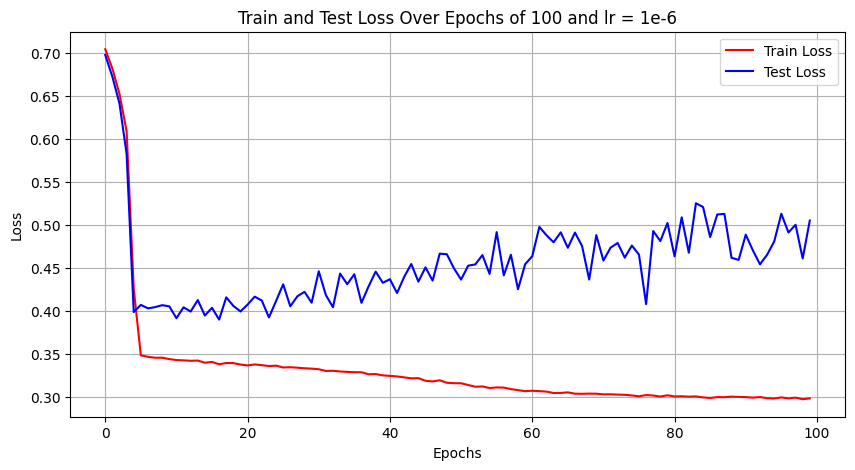

In [54]:
plt.figure(figsize=(10, 5))
plt.plot(range(num_iterates), UNet_trained_2[0], label='Train Loss', color='red')
plt.plot(range(num_iterates), UNet_trained_2[1], label='Test Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss Over Epochs of 100 and lr = 1e-6')
plt.legend()
plt.grid(True)x
plt.show()

In [16]:
import time
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_3 = UNet(n_class=1).to(device)

lr = 1e-5
optimizer = Adam(model_3.parameters(), lr=lr)

criterion = nn.BCEWithLogitsLoss()

def train(model, trainloader, testloader, criterion, optimizer, epochs, device):
  best_test = np.inf
  train_losses = []
  test_losses = []

  start_time = time.time()

  for epoch in range(epochs):
    epoch_loss = 0
    test_loss = 0
    epoch_start_time = time.time()


    model.train()
    for images, masks in tqdm(trainloader):

      images, masks = images.to(device), masks.to(device)

      optimizer.zero_grad()

      outputs = model(images)

      loss = criterion(outputs, masks)
      loss.backward()
      optimizer.step()
      loss = loss.cpu()
      epoch_loss += loss.item()

    model.eval()
    for image, masks in tqdm(testloader):
      images, masks = images.to(device), masks.to(device)
      outputs = model(images)
      loss = criterion(outputs, masks)
      loss = loss.cpu()
      test_loss += loss.item()

      
    epoch_train_loss = epoch_loss / len(trainloader)
    epoch_test_loss = test_loss / len(testloader)

    train_losses.append(epoch_train_loss)
    test_losses.append(epoch_test_loss)

    if test_loss/len(testloader) < best_test:
      best_test = test_loss/len(testloader)
      lr_str = str(lr)
      tile_size_str = str(tile_size)
      torch.save(model.state_dict(), 'unet_' + lr_str + "_" + tile_size_str + '_' + str(epochs) + '.pth')

    epoch_duration = time.time() - epoch_start_time
    print(f'Epoch {epoch+1}, Train Loss: {epoch_loss/len(trainloader)}, Test Loss: {test_loss/len(testloader)}')

  total_duration = time.time() - start_time
  total_duration_minutes = total_duration / 60
  print(f'Total Training Time: {total_duration_minutes:.2f} minutes')

  return train_losses, test_losses

    # plt.figure(figsize=(10, 5))
    # plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', color='red')
    # plt.plot(range(1, epochs + 1), test_losses, label='Test Loss', color='blue')
    # plt.xlabel('Epochs')
    # plt.ylabel('Loss')
    # plt.title('Train and Test Loss Over Epochs')
    # plt.legend()
    # plt.grid(True)
    # plt.show()


In [17]:
num_iterates = 50
UNet_trained_3 = train(model_3, train_loader, test_loader, criterion, optimizer, num_iterates, device)

100%|██████████| 37/37 [00:09<00:00,  3.71it/s]


Epoch 1, Train Loss: 0.547983642868899, Test Loss: 0.42953010628352295


100%|██████████| 37/37 [00:09<00:00,  3.72it/s]


Epoch 2, Train Loss: 0.3452540059649461, Test Loss: 0.40699848653496923


100%|██████████| 37/37 [00:10<00:00,  3.39it/s]


Epoch 3, Train Loss: 0.34046807084735986, Test Loss: 0.4065241052492245


100%|██████████| 37/37 [00:10<00:00,  3.67it/s]


Epoch 4, Train Loss: 0.33665262686239705, Test Loss: 0.42120917020617304


100%|██████████| 37/37 [00:09<00:00,  3.95it/s]


Epoch 5, Train Loss: 0.3333574926128259, Test Loss: 0.42067394143826253


100%|██████████| 37/37 [00:10<00:00,  3.69it/s]


Epoch 6, Train Loss: 0.3293650132679456, Test Loss: 0.4465127929642394


100%|██████████| 37/37 [00:09<00:00,  3.97it/s]


Epoch 7, Train Loss: 0.3244733416752235, Test Loss: 0.4512636887060629


100%|██████████| 37/37 [00:09<00:00,  3.86it/s]


Epoch 8, Train Loss: 0.3163417934163197, Test Loss: 0.46541116306105174


100%|██████████| 37/37 [00:09<00:00,  3.72it/s]


Epoch 9, Train Loss: 0.30831037225151386, Test Loss: 0.5056805489836512


100%|██████████| 37/37 [00:10<00:00,  3.60it/s]


Epoch 10, Train Loss: 0.3068010372336249, Test Loss: 0.4550059816321811


100%|██████████| 37/37 [00:09<00:00,  3.72it/s]


Epoch 11, Train Loss: 0.3018187705326725, Test Loss: 0.49375631559539485


100%|██████████| 37/37 [00:09<00:00,  3.72it/s]


Epoch 12, Train Loss: 0.3025002982467413, Test Loss: 0.4646848057572906


100%|██████████| 37/37 [00:09<00:00,  3.95it/s]


Epoch 13, Train Loss: 0.2989389259569548, Test Loss: 0.47294220489424627


100%|██████████| 37/37 [00:10<00:00,  3.70it/s]


Epoch 14, Train Loss: 0.29986215357643525, Test Loss: 0.4929710276223518


100%|██████████| 37/37 [00:09<00:00,  3.78it/s]


Epoch 15, Train Loss: 0.2980587141638672, Test Loss: 0.5117261333240045


100%|██████████| 37/37 [00:11<00:00,  3.30it/s]


Epoch 16, Train Loss: 0.2977163146275121, Test Loss: 0.4467255533547015


100%|██████████| 37/37 [00:10<00:00,  3.68it/s]


Epoch 17, Train Loss: 0.2939319814731543, Test Loss: 0.5193969407999838


100%|██████████| 37/37 [00:09<00:00,  3.71it/s]


Epoch 18, Train Loss: 0.2960562263489575, Test Loss: 0.5181089534952834


100%|██████████| 37/37 [00:11<00:00,  3.35it/s]


Epoch 19, Train Loss: 0.29490976654798595, Test Loss: 0.5023051814453022


100%|██████████| 37/37 [00:09<00:00,  3.74it/s]


Epoch 20, Train Loss: 0.29373044314215313, Test Loss: 0.475541217907055


100%|██████████| 37/37 [00:09<00:00,  3.70it/s]


Epoch 21, Train Loss: 0.2947065518111796, Test Loss: 0.450498286131266


100%|██████████| 37/37 [00:09<00:00,  3.77it/s]


Epoch 22, Train Loss: 0.293619599948461, Test Loss: 0.5648590161188228


100%|██████████| 37/37 [00:10<00:00,  3.70it/s]


Epoch 23, Train Loss: 0.294003228266799, Test Loss: 0.48336725218875987


100%|██████████| 37/37 [00:10<00:00,  3.70it/s]


Epoch 24, Train Loss: 0.291913607333963, Test Loss: 0.45947659660030055


100%|██████████| 37/37 [00:09<00:00,  3.74it/s]


Epoch 25, Train Loss: 0.29361505562288537, Test Loss: 0.49370388565836726


100%|██████████| 37/37 [00:09<00:00,  3.76it/s]


Epoch 26, Train Loss: 0.29464705570324046, Test Loss: 0.47813182263760956


100%|██████████| 37/37 [00:10<00:00,  3.70it/s]


Epoch 27, Train Loss: 0.2932437607968176, Test Loss: 0.5215284989492314


100%|██████████| 37/37 [00:09<00:00,  3.80it/s]


Epoch 28, Train Loss: 0.2909352667126301, Test Loss: 0.4677121592937289


100%|██████████| 37/37 [00:09<00:00,  4.04it/s]


Epoch 29, Train Loss: 0.29131554575586643, Test Loss: 0.4757354642088349


100%|██████████| 37/37 [00:09<00:00,  3.79it/s]


Epoch 30, Train Loss: 0.2926106171531452, Test Loss: 0.5580130146967398


100%|██████████| 37/37 [00:10<00:00,  3.69it/s]


Epoch 31, Train Loss: 0.2899392456621737, Test Loss: 0.513859352549991


100%|██████████| 37/37 [00:09<00:00,  3.79it/s]


Epoch 32, Train Loss: 0.2899347081075649, Test Loss: 0.5851014127602449


100%|██████████| 37/37 [00:09<00:00,  3.79it/s]


Epoch 33, Train Loss: 0.29139525123645327, Test Loss: 0.49762707062669703


100%|██████████| 37/37 [00:09<00:00,  3.75it/s]


Epoch 34, Train Loss: 0.2873585237743887, Test Loss: 0.5135660284274334


100%|██████████| 37/37 [00:08<00:00,  4.14it/s]


Epoch 35, Train Loss: 0.29309031900924604, Test Loss: 0.5168250452827763


100%|██████████| 37/37 [00:09<00:00,  3.72it/s]


Epoch 36, Train Loss: 0.2884169936784216, Test Loss: 0.4762660031383102


100%|██████████| 37/37 [00:10<00:00,  3.37it/s]


Epoch 37, Train Loss: 0.2872194618842489, Test Loss: 0.5003032656134786


100%|██████████| 37/37 [00:11<00:00,  3.36it/s]


Epoch 38, Train Loss: 0.28906096236125844, Test Loss: 0.5475761580306131


100%|██████████| 37/37 [00:09<00:00,  3.84it/s]


Epoch 39, Train Loss: 0.2879827935752031, Test Loss: 0.5359719649359986


100%|██████████| 37/37 [00:09<00:00,  3.72it/s]


Epoch 40, Train Loss: 0.2884108020445785, Test Loss: 0.4918832400360623


100%|██████████| 37/37 [00:09<00:00,  4.03it/s]


Epoch 41, Train Loss: 0.288471548994248, Test Loss: 0.5193865621412123


100%|██████████| 37/37 [00:11<00:00,  3.33it/s]


Epoch 42, Train Loss: 0.28720017170181145, Test Loss: 0.4845418249433105


100%|██████████| 37/37 [00:10<00:00,  3.44it/s]


Epoch 43, Train Loss: 0.288199975985933, Test Loss: 0.512116001264469


100%|██████████| 37/37 [00:09<00:00,  3.73it/s]


Epoch 44, Train Loss: 0.2873381558503654, Test Loss: 0.5172582727831763


100%|██████████| 37/37 [00:09<00:00,  3.72it/s]


Epoch 45, Train Loss: 0.28532018301052015, Test Loss: 0.5760821275211669


100%|██████████| 37/37 [00:10<00:00,  3.61it/s]


Epoch 46, Train Loss: 0.2862585816230323, Test Loss: 0.5070874795720384


100%|██████████| 37/37 [00:10<00:00,  3.65it/s]


Epoch 47, Train Loss: 0.28737230933699254, Test Loss: 0.49997269301801117


100%|██████████| 37/37 [00:09<00:00,  3.71it/s]


Epoch 48, Train Loss: 0.2850856106929682, Test Loss: 0.4936016451668095


100%|██████████| 37/37 [00:09<00:00,  3.77it/s]


Epoch 49, Train Loss: 0.2879077623522765, Test Loss: 0.49910184016098846


100%|██████████| 37/37 [00:09<00:00,  3.80it/s]

Epoch 50, Train Loss: 0.28712136097051, Test Loss: 0.49370968261280573
Total Training Time: 57.74 minutes


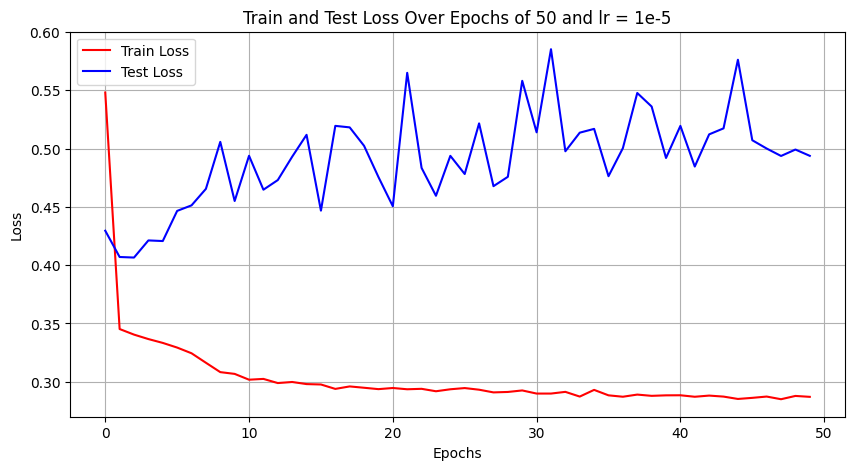

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(range(num_iterates), UNet_trained_3[0], label='Train Loss', color='red')
plt.plot(range(num_iterates), UNet_trained_3[1], label='Test Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss Over Epochs of 50 and lr = 1e-5')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
import time
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_4 = UNet(n_class=1).to(device)

lr = 1e-2
optimizer = Adam(model_4.parameters(), lr=lr)

criterion = nn.BCEWithLogitsLoss()

def train(model, trainloader, testloader, criterion, optimizer, epochs, device):
  best_test = np.inf
  train_losses = []
  test_losses = []

  start_time = time.time()

  for epoch in range(epochs):
    epoch_loss = 0
    test_loss = 0
    epoch_start_time = time.time()


    model.train()
    for images, masks in tqdm(trainloader):

      images, masks = images.to(device), masks.to(device)

      optimizer.zero_grad()

      outputs = model(images)

      loss = criterion(outputs, masks)
      loss.backward()
      optimizer.step()
      loss = loss.cpu()
      epoch_loss += loss.item()

    model.eval()
    for image, masks in tqdm(testloader):
      images, masks = images.to(device), masks.to(device)
      outputs = model(images)
      loss = criterion(outputs, masks)
      loss = loss.cpu()
      test_loss += loss.item()

      
    epoch_train_loss = epoch_loss / len(trainloader)
    epoch_test_loss = test_loss / len(testloader)

    train_losses.append(epoch_train_loss)
    test_losses.append(epoch_test_loss)

    if test_loss/len(testloader) < best_test:
      best_test = test_loss/len(testloader)
      lr_str = str(lr)
      tile_size_str = str(tile_size)
      torch.save(model.state_dict(), 'unet_' + lr_str + "_" + tile_size_str + '_' + str(epochs) + '.pth')

    epoch_duration = time.time() - epoch_start_time
    print(f'Epoch {epoch+1}, Train Loss: {epoch_loss/len(trainloader)}, Test Loss: {test_loss/len(testloader)}')

  total_duration = time.time() - start_time
  total_duration_minutes = total_duration / 60
  print(f'Total Training Time: {total_duration_minutes:.2f} minutes')

  return train_losses, test_losses

    # plt.figure(figsize=(10, 5))
    # plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', color='red')
    # plt.plot(range(1, epochs + 1), test_losses, label='Test Loss', color='blue')
    # plt.xlabel('Epochs')
    # plt.ylabel('Loss')
    # plt.title('Train and Test Loss Over Epochs')
    # plt.legend()
    # plt.grid(True)
    # plt.show()


In [20]:
num_iterates = 50
UNet_trained_4 = train(model_4, train_loader, test_loader, criterion, optimizer, num_iterates, device)

100%|██████████| 37/37 [00:09<00:00,  3.78it/s]


Epoch 1, Train Loss: 460764.5248741599, Test Loss: 0.4073308770721023


100%|██████████| 37/37 [00:10<00:00,  3.50it/s]


Epoch 2, Train Loss: 0.3540187277705283, Test Loss: 0.43080492035762685


100%|██████████| 37/37 [00:10<00:00,  3.62it/s]


Epoch 3, Train Loss: 0.34808767350340214, Test Loss: 0.45600171065008316


100%|██████████| 37/37 [00:09<00:00,  3.73it/s]


Epoch 4, Train Loss: 0.34756231569760554, Test Loss: 0.38807855224287185


100%|██████████| 37/37 [00:09<00:00,  3.72it/s]


Epoch 5, Train Loss: 0.34625342095623146, Test Loss: 0.39261889216062185


100%|██████████| 37/37 [00:10<00:00,  3.41it/s]


Epoch 6, Train Loss: 0.3460933149263665, Test Loss: 0.41363410933597666


100%|██████████| 37/37 [00:10<00:00,  3.40it/s]


Epoch 7, Train Loss: 0.3454018693316627, Test Loss: 0.45714145556494995


100%|██████████| 37/37 [00:10<00:00,  3.56it/s]


Epoch 8, Train Loss: 0.34148461099814725, Test Loss: 0.4482296818011516


100%|██████████| 37/37 [00:10<00:00,  3.63it/s]


Epoch 9, Train Loss: 0.34201771635058764, Test Loss: 0.4165494671544513


100%|██████████| 37/37 [00:09<00:00,  3.79it/s]


Epoch 10, Train Loss: 0.3423057899281785, Test Loss: 0.40627259740958344


100%|██████████| 37/37 [00:09<00:00,  4.07it/s]


Epoch 11, Train Loss: 0.34249682024725386, Test Loss: 0.4158252618602804


100%|██████████| 37/37 [00:10<00:00,  3.59it/s]


Epoch 12, Train Loss: 0.3439063028608625, Test Loss: 0.42520935470993454


100%|██████████| 37/37 [00:09<00:00,  3.76it/s]


Epoch 13, Train Loss: 0.3420144329602654, Test Loss: 0.4453226980325338


100%|██████████| 37/37 [00:09<00:00,  4.07it/s]


Epoch 14, Train Loss: 0.34123916964273193, Test Loss: 0.44837516425429164


100%|██████████| 37/37 [00:09<00:00,  3.91it/s]


Epoch 15, Train Loss: 0.3396147276602081, Test Loss: 0.4152242758789578


100%|██████████| 37/37 [00:09<00:00,  3.85it/s]


Epoch 16, Train Loss: 0.34089015942771694, Test Loss: 0.4241423155810382


100%|██████████| 37/37 [00:10<00:00,  3.40it/s]


Epoch 17, Train Loss: 0.3442068309397311, Test Loss: 0.5061336695342451


100%|██████████| 37/37 [00:09<00:00,  3.78it/s]


Epoch 18, Train Loss: 0.34261094819049576, Test Loss: 0.418680820513416


100%|██████████| 37/37 [00:09<00:00,  3.82it/s]


Epoch 19, Train Loss: 0.33942292036639676, Test Loss: 0.42768537957926056


100%|██████████| 37/37 [00:09<00:00,  4.07it/s]


Epoch 20, Train Loss: 0.33869698955803307, Test Loss: 0.42680785221022527


100%|██████████| 37/37 [00:09<00:00,  3.86it/s]


Epoch 21, Train Loss: 0.34002780571982666, Test Loss: 0.42563900230704127


100%|██████████| 37/37 [00:09<00:00,  3.73it/s]


Epoch 22, Train Loss: 0.3393667523019217, Test Loss: 0.4207186988882116


100%|██████████| 37/37 [00:09<00:00,  3.81it/s]


Epoch 23, Train Loss: 0.3412581066022048, Test Loss: 0.44557563155084046


100%|██████████| 37/37 [00:09<00:00,  3.72it/s]


Epoch 24, Train Loss: 0.34111720580305604, Test Loss: 0.41938240463669235


100%|██████████| 37/37 [00:10<00:00,  3.63it/s]


Epoch 25, Train Loss: 0.34059632715542576, Test Loss: 0.424061525512386


100%|██████████| 37/37 [00:10<00:00,  3.43it/s]


Epoch 26, Train Loss: 0.34173639249559995, Test Loss: 0.4766734236398259


100%|██████████| 37/37 [00:09<00:00,  3.83it/s]


Epoch 27, Train Loss: 0.3408874003468333, Test Loss: 0.42452761128142075


100%|██████████| 37/37 [00:09<00:00,  3.71it/s]


Epoch 28, Train Loss: 0.3398930246664866, Test Loss: 0.49331954846511017


100%|██████████| 37/37 [00:09<00:00,  3.87it/s]


Epoch 29, Train Loss: 0.3433912676834577, Test Loss: 0.4758160496885712


100%|██████████| 37/37 [00:10<00:00,  3.69it/s]


Epoch 30, Train Loss: 0.3414716924465186, Test Loss: 0.42325243112203237


100%|██████████| 37/37 [00:09<00:00,  3.77it/s]


Epoch 31, Train Loss: 0.3422392231185694, Test Loss: 0.42645318242343694


100%|██████████| 37/37 [00:10<00:00,  3.52it/s]


Epoch 32, Train Loss: 0.3404798844980227, Test Loss: 0.48094455656167623


100%|██████████| 37/37 [00:09<00:00,  3.77it/s]


Epoch 33, Train Loss: 0.3415992986914274, Test Loss: 0.4491565263754613


100%|██████████| 37/37 [00:09<00:00,  3.76it/s]


Epoch 34, Train Loss: 0.33973813308654605, Test Loss: 0.447914448944298


100%|██████████| 37/37 [00:09<00:00,  3.83it/s]


Epoch 35, Train Loss: 0.34050610621233246, Test Loss: 0.44187830348272583


100%|██████████| 37/37 [00:09<00:00,  3.88it/s]


Epoch 36, Train Loss: 0.3397671615050451, Test Loss: 0.4657841248286737


100%|██████████| 37/37 [00:09<00:00,  3.74it/s]


Epoch 37, Train Loss: 0.3379311989489439, Test Loss: 0.434096597135067


100%|██████████| 37/37 [00:09<00:00,  3.75it/s]


Epoch 38, Train Loss: 0.33765395891827504, Test Loss: 0.4437998658096468


100%|██████████| 37/37 [00:09<00:00,  3.74it/s]


Epoch 39, Train Loss: 0.33932173644771446, Test Loss: 0.4456554852627419


100%|██████████| 37/37 [00:09<00:00,  3.84it/s]


Epoch 40, Train Loss: 0.3416043858270387, Test Loss: 0.3982546800697172


100%|██████████| 37/37 [00:09<00:00,  3.74it/s]


Epoch 41, Train Loss: 0.340456236153841, Test Loss: 0.4347653533961322


100%|██████████| 37/37 [00:10<00:00,  3.63it/s]


Epoch 42, Train Loss: 0.3408056312316173, Test Loss: 0.5150506653495737


100%|██████████| 37/37 [00:09<00:00,  3.72it/s]


Epoch 43, Train Loss: 0.34260510673394073, Test Loss: 0.40983737038599477


100%|██████████| 37/37 [00:09<00:00,  3.72it/s]


Epoch 44, Train Loss: 0.33796539374098583, Test Loss: 0.40825049740237157


100%|██████████| 37/37 [00:10<00:00,  3.41it/s]


Epoch 45, Train Loss: 0.34013826878288306, Test Loss: 0.3992662852680361


100%|██████████| 37/37 [00:09<00:00,  3.84it/s]


Epoch 46, Train Loss: 0.33868047262768486, Test Loss: 0.4045568048148542


100%|██████████| 37/37 [00:09<00:00,  3.78it/s]


Epoch 47, Train Loss: 0.3382708119681558, Test Loss: 0.41901492790595907


100%|██████████| 37/37 [00:10<00:00,  3.56it/s]


Epoch 48, Train Loss: 0.3380519758809257, Test Loss: 0.46694473036237666


100%|██████████| 37/37 [00:09<00:00,  3.77it/s]


Epoch 49, Train Loss: 0.33906070867905747, Test Loss: 0.40329472760896423


100%|██████████| 37/37 [00:11<00:00,  3.35it/s]

Epoch 50, Train Loss: 0.3357093056814896, Test Loss: 0.4024223794002791
Total Training Time: 55.49 minutes


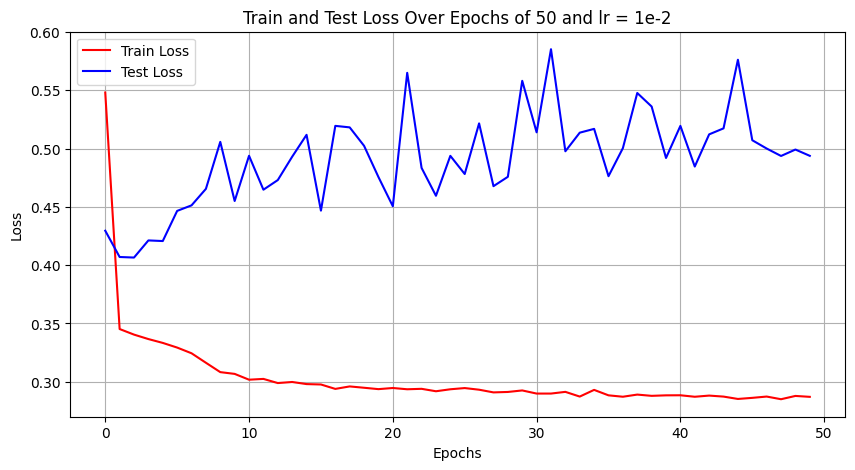

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(range(num_iterates), UNet_trained_3[0], label='Train Loss', color='red')
plt.plot(range(num_iterates), UNet_trained_3[1], label='Test Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss Over Epochs of 50 and lr = 1e-2')
plt.legend()
plt.grid(True)
plt.show()